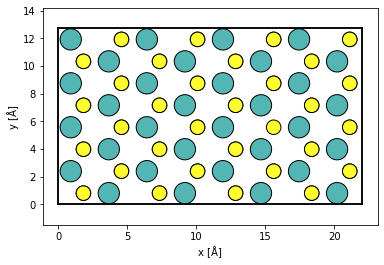

In [3]:
# 4D-STEM of MoS2 including a ptychographic phase reconstruction.
import matplotlib.pyplot as plt
import numpy as np

from ase.build import mx2

from abtem.visualize import show_atoms
from abtem.structures import orthogonalize_cell

# Create hexagonal supercell of MoS2
structure = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.127,
                size=(1, 1, 1), vacuum=10)
structure.pbc = True

# Orthogonalize cell and rotate and repeat it to match experiment.
atoms = orthogonalize_cell(structure)
atoms.rotate(-90, 'z', rotate_cell=True)
atoms*=(4,4,1)

# Switching x and y cell axes and centering to get positive coordinates.
atoms.cell=[[22.031686, 0, 0], [0, 12.72, 0], [0.0, 0.0, 12]]
atoms.center()

# Create S vacancy.
del atoms[64]

show_atoms(atoms);

In [4]:
# Create independent atom potential for the system.

from abtem.waves import Probe
from abtem.potentials import Potential

potential = Potential(atoms, sampling=0.04)

# Calculate defocus from experimental chromatic aberration parameters.
dE = 1.1
E = 80000
Cc = 1.72*10**6
spread = dE/E * Cc
Csval = 3e5

# Probe convergence semi-angle.
alpha = 21.4
    
# Create scanning probe with partly guessed but reasonable parameters.
probe = Probe(energy=E, semiangle_cutoff=alpha, defocus=0, focal_spread=spread, Cs=Csval,
              parameters={'C12':10, 'phi12':2.0}) # Adding some astigmatism.

In [5]:
# Define the scan with experimental scan sampling.
from abtem.detect import PixelatedDetector, AnnularDetector
from abtem.scan import GridScan

# Matching scans to experimental step sizes.
scanstep1 = 0.21
scanstep2 = 0.45
scanstart = [0, 0]
scanend = [atoms.cell[0][0], atoms.cell[1][1]]

gridscan1 = GridScan(start=scanstart, end=scanend, sampling=scanstep1)
gridscan2 = GridScan(start=scanstart, end=scanend, sampling=scanstep2)

# Define a pixelated 4D detector.
pixelated_detector1 = PixelatedDetector(max_angle=5*alpha, resample='uniform', save_file='iam_mos2_0.21_uni.hdf5')
pixelated_detector2 = PixelatedDetector(max_angle=5*alpha, save_file='iam_mos2_0.45.hdf5')

# Define bright and dark field annular detectors.
bf_detector = AnnularDetector(inner=0, outer=alpha)
adf_detector = AnnularDetector(inner=3*alpha, outer=4*alpha)

In [115]:
# Running the multislice simulation takes around 10 minutes.
measurements = probe.scan(gridscan1, [pixelated_detector1], potential)
measurements_ptycho = probe.scan(gridscan2, [pixelated_detector2], potential)

Potential:   0%|          | 0/24 [00:00<?, ?it/s]

Scan:   0%|          | 0/6405 [00:00<?, ?it/s]

Potential:   0%|          | 0/24 [00:00<?, ?it/s]

Scan:   0%|          | 0/1421 [00:00<?, ?it/s]

In [6]:
# Reading saved measurement from disk.
from abtem.measure import Measurement

measurements = Measurement.read('iam_mos2_0.21_uni.hdf5')
measurements_ptycho = Measurement.read('iam_mos2_0.45.hdf5')

In [8]:
# Add Poisson noise to 4D measurement, and integrate for BF, ADF and iCOM.
from abtem.noise import poisson_noise
from abtem.measure import center_of_mass

noisy = poisson_noise(measurements, 3*10**5)

bf = bf_detector.integrate(noisy)
bf_diff = bf_detector.integrate(noisy).diffractograms()

adf = adf_detector.integrate(noisy)
adf_diff = adf_detector.integrate(noisy).diffractograms()

icom = center_of_mass(noisy, return_icom=True)
icom_diff = center_of_mass(noisy, return_icom=True).diffractograms()

In [11]:
# Bandlimit and add Poisson noise to the 4D measurement, then reconstruct phase with the ePIE algorithm.
from abtem.measure import bandlimit
from abtem.reconstruct import epie

probe_guess = probe.copy()
probe_guess.ctf.set_parameters({})
    
limited = bandlimit(measurements_ptycho, 5*alpha, taper=0.0)
noisy_ptycho = poisson_noise(limited, 3*10**5)

reconstructions = epie(noisy_ptycho, probe_guess, max_angle=5*alpha, maxiter=5, return_iterations=True, fix_com=True, fix_probe=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

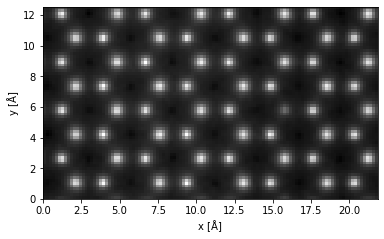

In [12]:
# The first index 0 chooses the image, the second index -1 the last reconstruction.
ptycho = reconstructions[0][-1].angle()
ptycho_diff = ptycho.diffractograms()

ptycho.show();

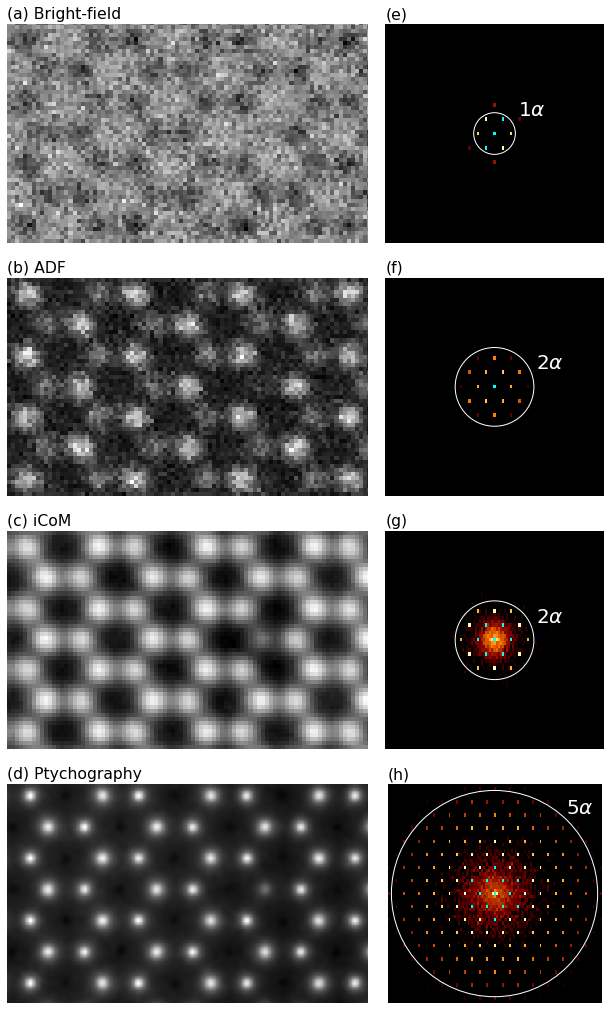

In [13]:
# Plotting a figure to reproduce Figure 2 of doi:10.1038/s41586-018-0298-5.
# Note that the simulation was done for the periodic supercell, but the plotted
# areas are slightly cropped below to match the experimental field of view.

from copy import copy

cmapdiff = copy(plt.cm.afmhot)
cmapdiff.set_over('cyan')

from matplotlib.patches import Circle
c1 = Circle((0, 0), 0.45, edgecolor='white', facecolor='none')
c2 = Circle((0, 0), 0.85, edgecolor='white', facecolor='none')
c3 = Circle((0, 0), 0.85, edgecolor='white', facecolor='none')
c4 = Circle((0, 0), 2.45, edgecolor='white', facecolor='none')

fig, axes = plt.subplots(4, 2, figsize=(20,18), gridspec_kw={'hspace': 0.16, 'wspace': -0.62})

plt.rcParams.update({'font.size': 13})

for ax in axes.flat:
        ax.set_axis_off()

bf.show(ax=axes[0,0])
axes[0,0].set_title('(a) Bright-field', x=0, ha='left')
axes[0,0].set_xlim([2.7,atoms.cell[0][0]-1.0])
axes[0,0].set_ylim([0,atoms.cell[1][1]-1.6])

bf_diff.show(ax=axes[0,1], log_scale=True, cmap=cmapdiff, vmin=22.5, vmax=24)
axes[0,1].set_title('(e)', x=0, ha='left')
axes[0,1].add_patch(c1)
axes[0,1].text(0.5, 0.4, r'1$\alpha$', fontsize=20, color='white')

adf.show(ax=axes[1,0]);
axes[1,0].set_title('(b) ADF', x=0, ha='left')
axes[1,0].set_xlim([2.7,atoms.cell[0][0]-1.0])
axes[1,0].set_ylim([0,atoms.cell[1][1]-1.6])

adf_diff.show(ax=axes[1,1], log_scale=True, cmap=cmapdiff, vmin=15, vmax=22);
axes[1,1].set_title('(f)', x=0, ha='left')
axes[1,1].add_patch(c2)
axes[1,1].text(0.9, 0.4, r'2$\alpha$', fontsize=20, color='white')

icom.show(ax=axes[2,0])
axes[2,0].set_title('(c) iCoM', x=0, ha='left')
axes[2,0].set_xlim([2.7,atoms.cell[0][0]-1.0])
axes[2,0].set_ylim([0,atoms.cell[1][1]-1.6])

icom_diff.show(ax=axes[2,1], log_scale=True, cmap=cmapdiff, vmin=2, vmax=12);
axes[2,1].set_title('(g)', x=0, ha='left')
axes[2,1].add_patch(c3)
axes[2,1].text(0.9, 0.4, r'2$\alpha$', fontsize=20, color='white');

ptycho.interpolate(0.04).show(ax=axes[3,0])
axes[3,0].set_title('(d) Ptychography', x=0, ha='left')
axes[3,0].set_xlim([2.7,atoms.cell[0][0]-1.0])
axes[3,0].set_ylim([0,atoms.cell[1][1]-1.6])

ptycho_diff.show(ax=axes[3,1], log_scale=True, cmap=cmapdiff, vmin=0, vmax=10);
axes[3,1].set_title('(h)', x=0, ha='left')
axes[3,1].add_patch(c4)
axes[3,1].text(1.7, 1.9, r'5$\alpha$', fontsize=20, color='white');

plt.savefig('MoS2_Svac.pdf')